# Test and Visualize Results

In [1]:
import json
import ray
from ray import tune
from model import RNN,  Base
from utils import plot_data, get_input_data, get_dataloader, get_input_data_1D
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Utility funtions

In [2]:
def get_config(json_config_path):
    with open(json_config_path, 'r') as fp:
        best_config = json.load(fp)
    return best_config

def load_model(params):
    print(f'Loading {params["model_name"]} model...')
    model = Base(input_size=params['input_size'], 
                hidden_size = params["hidden_size"],
                num_layers = params["num_layers"],
                output_size=1 if params['data_dim'] == 1 else 3,
                model = params['model_name'])

    chkpoints_list = [i for i in os.listdir(params['dir']) if i.startswith("checkpoint")]
    last_checkpoint = sorted(chkpoints_list, key=lambda x: int(x.split('_')[-1]))[-1]
    
    print(f'Loading model: {last_checkpoint} from {params["dir"]}...')
    chkpoint_state_dict, optim_state = torch.load(os.path.join(params['dir'], f'{last_checkpoint}', "checkpoint"))
    model.load_state_dict(chkpoint_state_dict)
    return model

In [3]:
def test_accuracy(net, test_loader, device="cpu"):
    
    net.to(device)
    criterion = nn.MSELoss()
    loss = 0
    # total = 0
    test_pred = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs, _ = net(input)
            # _, predicted = torch.max(outputs.data, 1)
            loss += criterion(outputs, labels).cpu().numpy()
            test_pred.append(outputs.cpu().numpy())
    return loss / len(test_loader), np.concatenate(np.array(test_pred), axis=0)


In [4]:
def get_mse(pred, labels):
    criterion = nn.MSELoss()
    return criterion(torch.tensor(pred).clone().detach() , torch.tensor(labels)).item()


In [5]:
def get_all_mse(pred, labels):
    all_losses = []
    for i in range(pred.shape[1]): # output size 
        all_losses.append(get_mse(pred[:, i], labels[:, i]))
    return all_losses, get_mse(pred[:, 0], labels[:, 0]) # return mse for x, y, theta and total mse


In [25]:
def show_plots(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    plt.figure(figsize=(20, 10))
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])    

        plt.subplot(3, 1, 1)
        plt.plot(nn_preds[:lim, 0], label='X pred')
        plt.plot(gt[:lim, 0], label='X true')
        plt.plot(kalman_pred[:lim, 0], label='X kalman')
        plt.plot(ekf_pred[:lim, 0], label='X EKF')
        plt.plot(ukf_pred[:lim, 0], label='X UKF')
        plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        plt.subplot(3, 1, 2)
        plt.plot(nn_preds[:lim, 1], label='Y pred')
        plt.plot(gt[:lim, 1], label='Y true')
        plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        plt.subplot(3, 1, 3)
        plt.plot(nn_preds[:lim, 2], label='Theta pred')
        plt.plot(gt[:lim, 2], label='Theta true')
        plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [29]:
def get_csv_results(eval_csv_dir, params):
    config = get_config(params["json_config_path"])
    config.update(params)

    model = load_model(config)

    # test_df = pd.read_csv(EVAL_DATA_DIR)
    if params["data_dim"] == 2:
        test_dataset = get_input_data(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)

        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")

        kalman_pred = np.array(test_dataset[2])
        ekf_pred = np.array(test_dataset[3])
        ukf_pred = np.array(test_dataset[4])
        
        nn_loss_dims, nn_loss = get_all_mse(nn_preds, test_dataset[1])
        print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        kf_loss_dims, kf_loss = get_all_mse(kalman_pred, test_dataset[1])
        print(f"KF MSE: {kf_loss_dims}, {kf_loss}")
        ekf_loss_dims, ekf_loss = get_all_mse(ekf_pred, test_dataset[1])
        print(f"EKF MSE: {ekf_loss_dims}, {ekf_loss}")
        ukf_loss_dims, ukf_loss = get_all_mse(ukf_pred, test_dataset[1])
        print(f"UKF MSE: {ukf_loss_dims}, {ukf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss

    else:
        test_dataset = get_input_data_1D(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)
        
        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")

        kalman_pred = np.array(test_dataset[2])
        
        nn_loss_dims, nn_loss = get_all_mse(nn_preds, test_dataset[1])
        print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        kf_loss_dims, kf_loss = get_all_mse(kalman_pred, test_dataset[1])
        print(f"KF MSE: {kf_loss_dims}, {kf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss




## Action

### LSTM

In [30]:
data_dim = 2
model_name = "LSTM"
# eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
eval_dir_path = f"data/{data_dim}D/evaluation_data"
eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


params = {
    "batch_size": 100,
    "model_name": model_name,
    "input_size": 19 if data_dim == 2 else 9,
    "output_size": 3 if data_dim == 2 else 1,
    'model_name': model_name,
    'data_dim': data_dim,
    "json_config_path": json_config_path,
    "data_dim": data_dim,
    "plot_limit": 1000, # -1 for all
    "save_plots": True,
    "save_dir": f"./results/{data_dim}D/plots",
}

params

{'batch_size': 100,
 'model_name': 'LSTM',
 'input_size': 19,
 'output_size': 3,
 'data_dim': 2,
 'json_config_path': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_2D/best_config_LSTM.json',
 'plot_limit': 1000,
 'save_plots': True,
 'save_dir': './results/2D/plots'}

### 2D Results

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading LSTM model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-04_00-08-54/train_ray_570c3_00014_14_lr=0.0004,num_layers=5,sequence_length=100_2023-05-04_00-36-31...
Test loss: 3.7866452024096535
NN MSE: [5.781642172642184, 4.615510843819852, 0.9627826721918135], 5.781642172642184
KF MSE: [0.5799759692286736, 0.3096836211995979, 0.8511548826699521], 0.5799759692286736
EKF MSE: [2.636113480446211, 0.8049022601852719, 1.3284665111553708], 2.636113480446211
UKF MSE: [1.107968268467195, 1.093959072521493, 1.3306311775450679], 1.107968268467195
CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
Loading LSTM model...
Loading model: checkpoint_000099 from /home/anees.hashmi/ray_results/train_ray_2023-05-04_00-08-54/train_ray_570c3_00014_14_lr=0.0004,num_layers=5,sequence_length=100_2023-05-04_00-36-31...
Test loss: 92.38882343857377
NN MSE: [53.82220370202211, 223.06321987202347,

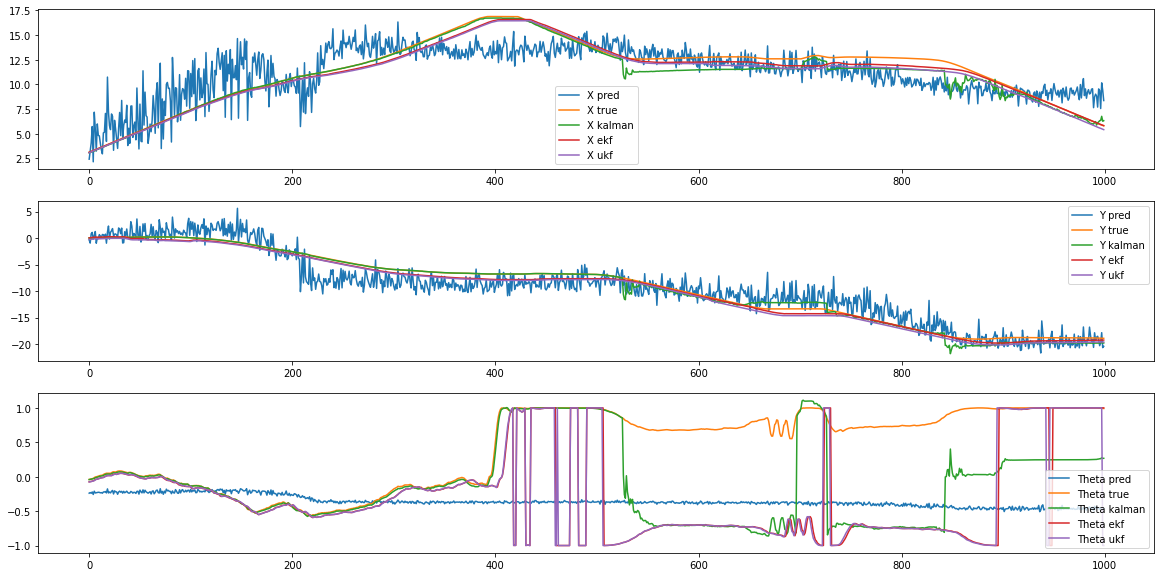

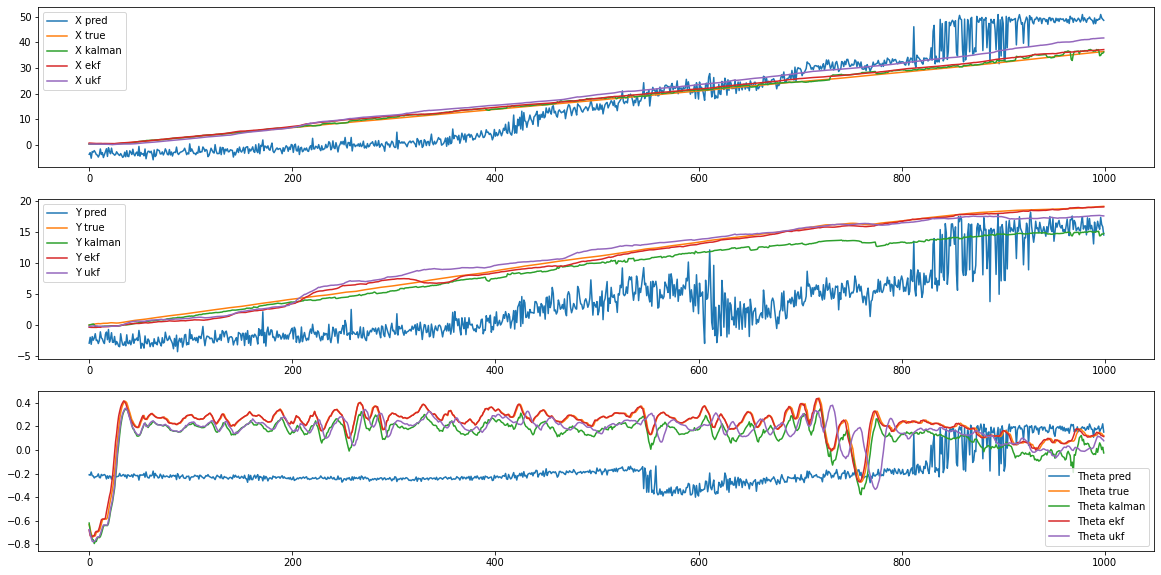

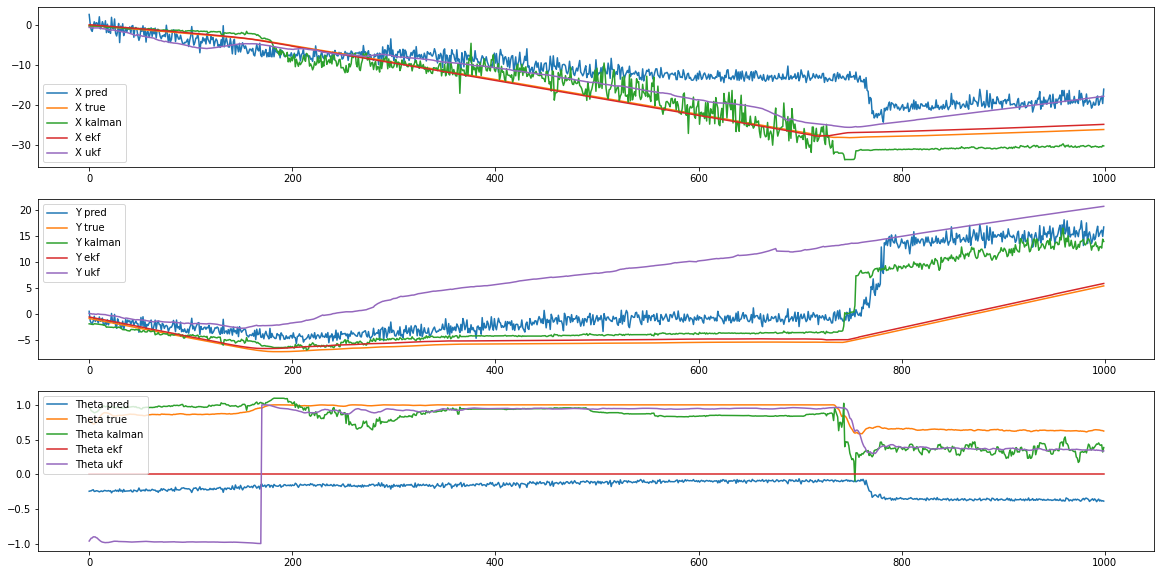

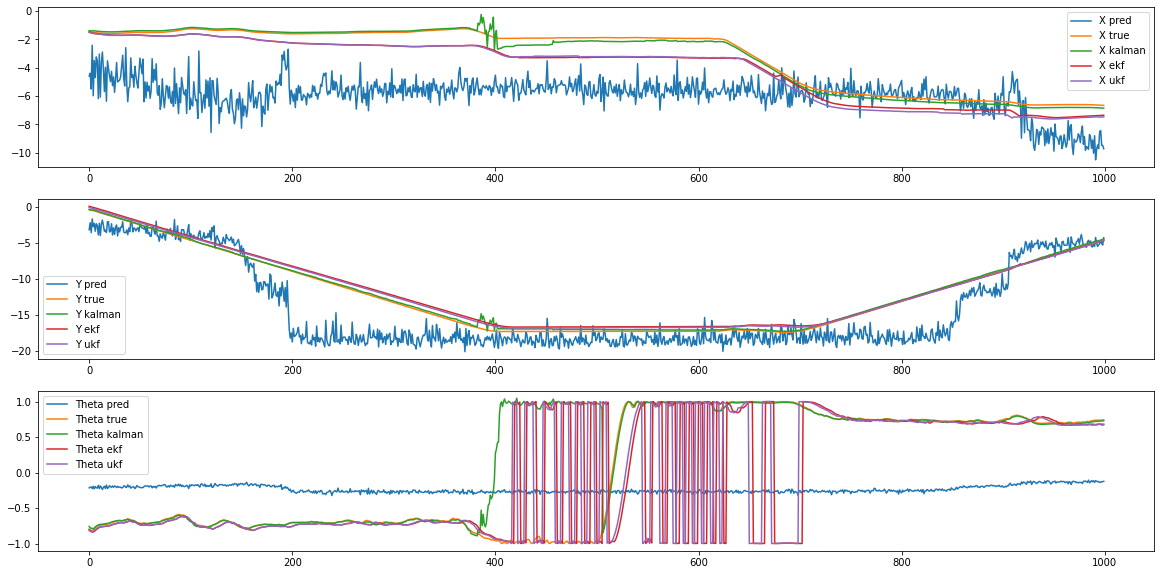

In [35]:
if data_dim == 2:
    kalman_mse_x = []
    kalman_mse_y = []
    kalman_mse_theta = []

    nn_mse_x = []
    nn_mse_y = []
    nn_mse_theta = []

    ekf_mse_x = []
    ekf_mse_y = []
    ekf_mse_theta = []

    ukf_mse_x = []
    ukf_mse_y = []
    ukf_mse_theta = []

    kalman_mse_total = []
    nn_mse_total = []
    ekf_mse_total = []
    ukf_mse_total = []

    test_set = []
    test_model = []

    for csv_name in os.listdir(eval_dir_path):
        csv_dir = os.path.join(eval_dir_path, csv_name)
        print(f"CSV: {eval_csv_dir}")
        # get_csv_results(csv_dir)
        params['save_name'] = csv_name.split(".")[0] # for saving plots
        mse_array = get_csv_results(csv_dir, params)

        kf_loss_dims = mse_array[0]
        kf_loss = mse_array[1]
        nn_loss_dims = mse_array[2]
        nn_loss = mse_array[3]
        ekf_loss_dims = mse_array[4]
        ekf_loss = mse_array[5]
        ukf_loss_dims = mse_array[6]
        ukf_loss = mse_array[7]

        # kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss = mse_array

        kalman_mse_total.append(kf_loss)
        nn_mse_total.append(nn_loss)
        ekf_mse_total.append(ekf_loss)
        ukf_mse_total.append(ukf_loss)

        kalman_mse_x.append(kf_loss_dims[0])
        kalman_mse_y.append(kf_loss_dims[1])
        kalman_mse_theta.append(kf_loss_dims[2])

        ekf_mse_x.append(ekf_loss_dims[0])
        ekf_mse_y.append(ekf_loss_dims[1])
        ekf_mse_theta.append(ekf_loss_dims[2])

        ukf_mse_x.append(ukf_loss_dims[0])
        ukf_mse_y.append(ukf_loss_dims[1])
        ukf_mse_theta.append(ukf_loss_dims[2])

        nn_mse_x.append(nn_loss_dims[0])
        nn_mse_y.append(nn_loss_dims[1])
        nn_mse_theta.append(nn_loss_dims[2])

        test_set.append(csv_dir)
        test_model.append(model_name)


        print("====================================")
        print("====================================")
        print("====================================")

    results_dict = {
        "Test set": test_set,
        "Test model": test_model,

        "Total Kalman MSe": kalman_mse_total,
        "Total NN MSE": nn_mse_total,
        "Total EKF MSE": ekf_mse_total,
        "Total UKF MSE": ukf_mse_total,

        "Kalman MSE X": kalman_mse_x,
        "NN MSE X": nn_mse_x,
        "EKF MSE X": ekf_mse_x,
        "UKF MSE X": ukf_mse_x,

        "Kalman MSE Y": kalman_mse_y,
        "NN MSE Y": nn_mse_y,
        "EKF MSE Y": ekf_mse_y,
        "UKF MSE Y": ukf_mse_y,

        "Kalman MSE Theta": kalman_mse_theta,
        "NN MSE Theta": nn_mse_theta,
        "EKF MSE Theta": ekf_mse_theta,
        "UKF MSE Theta": ukf_mse_theta,
    }

    results_df = pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])
    results_df

In [36]:
results_df

Total Kalman MSe  \
Test model Test set                                                               
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.579976   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...         16.733372   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...         26.643676   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.196642   

                                                               Total NN MSE  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      5.781642   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     53.822204   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     77.640186   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...     16.000607   

                                                               Total EKF MSE  \
Test model Test set                                                            
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...       2.636113   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...       2.876229   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...       1.042424   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...       1.403513   

                                                               Total UKF MSE  \
Test model Test set                                                            
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...       1.107968   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...   23881.519942   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...    1780.499879   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...       0.685338   

                                                               Kalman MSE X  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.579976   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     16.733372   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     26.643676   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.196642   

                                                                NN MSE X  \
Test model Test set                                                        
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...   5.781642   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...  53.822204   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...  77.640186   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...  16.000607   

                                                               EKF MSE X  \
Test model Test set                                                        
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...   2.636113   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...   2.876229   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...   1.042424   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...   1.403513   

                                                                  UKF MSE X  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      1.107968   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...  23881.519942   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...   1780.499879   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.685338   

                                                               Kalman MSE Y  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.309684   
           data/2D/evaluat

In [16]:

kalman_mse_x = []
kalman_mse_y = []
kalman_mse_theta = []

nn_mse_x = []
nn_mse_y = []
nn_mse_theta = []

kalman_mse_total = []
nn_mse_total = []

test_set = []
test_model = []

for csv_name in os.listdir(eval_dir_path):
    csv_dir = os.path.join(eval_dir_path, csv_name)
    print(f"CSV: {eval_csv_dir}")
    # get_csv_results(csv_dir)

    mse_array = get_csv_results(csv_dir, params)

    kf_loss_dims = mse_array[0]
    kf_loss = mse_array[1]
    nn_loss_dims = mse_array[2]
    nn_loss = mse_array[3]

    # kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss = mse_array

    kalman_mse_total.append(kf_loss)
    nn_mse_total.append(nn_loss)

    kalman_mse_x.append(kf_loss_dims[0])
    kalman_mse_y.append(kf_loss_dims[1])
    kalman_mse_theta.append(kf_loss_dims[2])
    

    nn_mse_x.append(nn_loss_dims[0])
    nn_mse_y.append(nn_loss_dims[1])
    nn_mse_theta.append(nn_loss_dims[2])

    test_set.append(csv_dir)
    test_model.append(model_name)


    print("====================================")
    print("====================================")
    print("====================================")


In [10]:
results_dict = {
    "Test set": test_set,
    "Test model": test_model,
    "Total Kalman MSe": kalman_mse_total,
    "Total NN MSE": nn_mse_total,
    "Kalman MSE X": kalman_mse_x,
    "NN MSE X": nn_mse_x,
    "Kalman MSE Y": kalman_mse_y,
    "NN MSE Y": nn_mse_y,
    "Kalman MSE Theta": kalman_mse_theta,
    "NN MSE Theta": nn_mse_theta,
}

pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])

Total Kalman MSe  \
Test model Test set                                                               
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.579976   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...         16.733372   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...         26.643676   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.196642   

                                                               Total NN MSE  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      5.572463   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     53.777673   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     79.244218   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...     15.998134   

                                                               Kalman MSE X  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.579976   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...     16.733372   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     26.643676   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.196642   

                                                                NN MSE X  \
Test model Test set                                                        
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...   5.572463   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...  53.777673   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...  79.244218   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...  15.998134   

                                                               Kalman MSE Y  \
Test model Test set                                                           
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.309684   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...    144.545670   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...     39.187032   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.188719   

                                                                 NN MSE Y  \
Test model Test set                                                         
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...    4.484904   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...  222.180667   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...  111.960835   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...    6.635551   

                                                               Kalman MSE Theta  \
Test model Test set                                                               
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...          0.851155   
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...          0.088123   
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...          0.108900   
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...          0.486593   

                                                               NN MSE Theta  
Test model Test set                                                          
LSTM       data/2D/evaluation_data/intel_alpha_8_run_2_mer...      0.962080  
           data/2D/evaluation_data/fbcampus_alpha_4_run_2_...      0.281057  
           data/2D/evaluation_data/fbcampus_alpha_8_run_2_...      0.919128  
           data/2D/evaluation_data/intel_alpha_4_run_2_mer...      0.420809

### RNN

In [11]:
data_dim = 2
model_name = "RNN"
# eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
eval_dir_path = f"data/{data_dim}D/evaluation_data"
eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


params = {
    "batch_size": 100,
    "model_name": model_name,
    "input_size": 19 if data_dim == 2 else 9,
    "output_size": 3 if data_dim == 2 else 1,
    'model_name': model_name,
    'data_dim': data_dim,
}


kalman_mse_x = []
kalman_mse_y = []
kalman_mse_theta = []

nn_mse_x = []
nn_mse_y = []
nn_mse_theta = []

kalman_mse_total = []
nn_mse_total = []

test_set = []
test_model = []

for csv_name in os.listdir(eval_dir_path):
    csv_dir = os.path.join(eval_dir_path, csv_name)
    print(f"CSV: {eval_csv_dir}")
    # get_csv_results(csv_dir)

    kf_loss_dims, kf_loss, nn_loss_dims, nn_loss = get_csv_results(csv_dir, params)

    kalman_mse_total.append(kf_loss)
    nn_mse_total.append(nn_loss)

    kalman_mse_x.append(kf_loss_dims[0])
    kalman_mse_y.append(kf_loss_dims[1])
    kalman_mse_theta.append(kf_loss_dims[2])

    nn_mse_x.append(nn_loss_dims[0])
    nn_mse_y.append(nn_loss_dims[1])
    nn_mse_theta.append(nn_loss_dims[2])

    test_set.append(csv_dir)
    test_model.append(model_name)


    print("====================================")
    print("====================================")
    print("====================================")


results_dict = {
    "Test set": test_set,
    "Test model": test_model,
    "Total Kalman MSe": kalman_mse_total,
    "Total NN MSE": nn_mse_total,
    "Kalman MSE X": kalman_mse_x,
    "NN MSE X": nn_mse_x,
    "Kalman MSE Y": kalman_mse_y,
    "NN MSE Y": nn_mse_y,
    "Kalman MSE Theta": kalman_mse_theta,
    "NN MSE Theta": nn_mse_theta,
}

pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv


KeyError: 'json_config_path'